In [11]:
#setup the environment for the NN, depending on if it to be run on Google Colab, or a local device (with or without a CUDA-enable GPU)

import os
import csv
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
#set up environment
REBUILD_DATA = True # set to true to one once, then back to false unless you want to change something in your training data.
GOOGLE_COLAB = False #set to true if running in google colab, false other wise

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

if GOOGLE_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')
    training_data_filename = "/content/gdrive/My Drive/Colab Notebooks/LoL-Predictor/datasets/training_data.csv" #for running on google colab notebooks
    model_log_filename = "/content/gdrive/My Drive/Colab Notebooks/LoL-Predictor/logs/model.log"
    numpy_training_data = "/content/gdrive/My Drive/Colab Notebooks/LoL-Predictor/datasets/training_data.npy"
else:
    training_data_filename = "C:\\Users\\James Ting\\OneDrive - McGill University\\Personal\\Personal Projects\\LoL-Predictor\\datasets\\training_data.csv"
    model_log_filename = "C:\\Users\\James Ting\\OneDrive - McGill University\\Personal\\Personal Projects\\LoL-Predictor\\logs\\model.log"
    numpy_training_data = "C:\\Users\\James Ting\\OneDrive - McGill University\\Personal\\Personal Projects\\LoL-Predictor\\datasets\\training_data.npy"

Running on the CPU


In [12]:

class DataSetReader():
    LABELS = {'blue_win':0 , 'red_win':1}
    training_data = []
    blue_win_count = 0
    red_win_count = 0
    training_data_location = training_data_filename
    exclude_columns = (0, 23, 25, 26, 29, 98, 100, 101, 104, 173, 175, 176, 
                       179, 248, 250, 251, 254, 323, 325, 326, 329, 398, 400, 
                       401, 404, 473, 475, 476, 479, 548, 550, 551, 554, 623, 
                       625, 626, 629, 698, 700, 701, 704)


    def read_training_data(self):
      with open(self.training_data_location,'r') as f:
        next(f) #skip the line with the column names
        for row in f:
          matchData = self.read_and_exclude_row(row,self.exclude_columns)
          result = None
          if(matchData[-1] == 1): #red win, blue loos
            result = 1 #[1,0]
            self.red_win_count += 1
          elif (matchData[-1] == 0): #red loss, blue win
            result = 0
            self.blue_win_count += 1
          else:
            raise TypeError
          self.training_data.append([np.array(matchData[:-2]),result])
      
      
      f.close()
      np.random.shuffle(self.training_data)
      np.save(numpy_training_data, self.training_data)
      print('Blue Win Count:',self.blue_win_count)
      print('Red Win Count:', self.red_win_count)
          
          

    def read_and_exclude_row(self,row,exclude_column_indices):
        row_list = row.split(',')
        cleaned_row = []
        append = cleaned_row.append
        for index,value in enumerate(row_list):
            if index not in exclude_column_indices:
              if value == 'FALSE' or value == 'False':
                append(0)
              elif value == 'TRUE' or value == 'True':
                append(1)
              else:
                append(float(value))
        return cleaned_row

    def get_input_size(self):
      return len(self.training_data[0][0])
    
    def get_training_set(self):
      return self.training_data


In [13]:
if REBUILD_DATA:
  data_reader = DataSetReader()
  data_reader.read_training_data()
  INPUT_SIZE = data_reader.get_input_size()

Blue Win Count: 1605
Red Win Count: 1640


In [14]:
class Net(nn.Module):
    #constructor
    def __init__(self):
        super().__init__() #superclass constructor
        self.fc1 = nn.Linear(INPUT_SIZE,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,1)

        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.sigmoid = nn.LogSigmoid()
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.batchnorm1(x)
        x = F.relu(self.fc2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [15]:
net = Net()
print(net)

trainset = np.load(numpy_training_data,allow_pickle=True)
print("Size of data set: ",len(trainset))

optimizer = optim.Adam(net.parameters(),lr = 0.001)
loss_function = nn.BCEWithLogitsLoss()

X = torch.Tensor([i[0] for i in trainset])
X = torch.log10(X + torch.ones(INPUT_SIZE)) #normalize the data to put it through a log(x+1) function
y = torch.Tensor([i[1] for i in trainset])

VAL_PERCENT = 0.1
val_size = int(len(X)*VAL_PERCENT)

train_X = X[:-val_size]
train_y = y[:-val_size]
test_X = X[-val_size:]
test_y = y[-val_size:]


BATCH_SIZE = 100
EPOCHS = 1

Net(
  (fc1): Linear(in_features=732, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sigmoid): LogSigmoid()
)
Size of data set:  3245


In [16]:
def forward_pass(X,y,train = False):
    if train:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs,y)]
    print(outputs)
    print(y)
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs,y)

    if train:
        loss.backward()
        optimizer.step()
    return acc, loss

def test(size=32):
    X, y = test_X[:size], test_y[:size]
    val_acc, val_loss = forward_pass(X.view(-1,INPUT_SIZE).to(device), y.to(device))
    return val_acc, val_loss

def train(net):
    with open(model_log_filename,"a+") as f:
        for epoch in range(EPOCHS):
                for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:100] ..for now just to dev
                    batch_X = train_X[i:i+BATCH_SIZE].view(-1,INPUT_SIZE)
                    batch_y = train_y[i:i+BATCH_SIZE]
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                    acc, loss = forward_pass(batch_X, batch_y, train=True)
                    if i % 50 == 0:
                        val_acc, val_loss = test(size=100)
                        f.write(f"{MODEL_NAME},{round(float(time.time()),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")

In [17]:
MODEL_NAME = f"model-{int(time.time())}"
last_model_name = MODEL_NAME
train(net)

0%|          | 0/30 [00:00<?, ?it/s]
tensor([[-1.5296e-01],
        [ 9.4789e-02],
        [-7.3367e-01],
        [ 2.7791e-01],
        [-3.5780e-01],
        [-8.3441e-03],
        [-3.1158e-01],
        [-8.1428e-02],
        [ 9.5375e-02],
        [ 8.2817e-02],
        [ 5.2893e-01],
        [ 5.5905e-01],
        [-6.4042e-01],
        [ 4.9102e-01],
        [ 5.5422e-01],
        [-8.7027e-01],
        [ 1.4470e-01],
        [ 8.1077e-02],
        [-5.5153e-01],
        [-4.7824e-01],
        [ 1.1397e+00],
        [ 5.5369e-01],
        [-1.8026e-02],
        [-6.8706e-01],
        [ 1.0581e-01],
        [-4.6222e-01],
        [-1.4186e-02],
        [ 9.1851e-01],
        [ 5.9584e-01],
        [ 1.6933e+00],
        [-4.7715e-01],
        [-7.0536e-01],
        [ 8.2306e-01],
        [ 1.7527e-01],
        [-3.6826e-01],
        [-6.4905e-02],
        [ 7.5150e-02],
        [-5.9727e-01],
        [-4.3336e-01],
        [-1.8020e-01],
        [-4.2289e-01],
        [-1.6961e-01

RuntimeError: all elements of input should be between 0 and 1

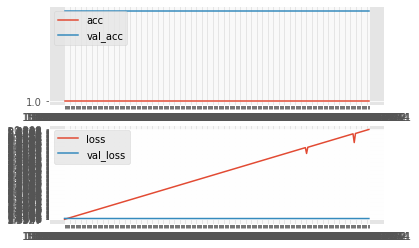

In [18]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")
model_name = last_model_name

def create_acc_loss_graph(model_name):
    contents = open(model_log_filename,"r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
            times.append(timestamp)
            accuracies.append(acc)
            losses.append(loss)

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))


    fog = plt.figure()

    ax1 = plt.subplot2grid((2,1),(0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times,losses, label="loss")
    ax2.plot(times,val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

create_acc_loss_graph(model_name)
